In [1]:
import os

try:
    snakemake
except NameError:
    from snakemk_util import load_rule_args
    
    os.chdir('../..')
    
    snakemake = load_rule_args(
        snakefile = os.getcwd() + "/workflow/Snakefile",
        rule_name = 'benchmark_lapa',
        root = '..',
    )

In [2]:
import matplotlib.pyplot as plt
import pyranges as pr
from lapa.result import LapaResult
from sklearn.metrics import precision_recall_curve, auc

In [4]:
core_cols = ['Chromosome', 'Start', 'End', 'Strand']

In [14]:
result_quantseq = LapaResult(snakemake.input['quantseq'], tpm_cutoff=1)
result_drna_ont_end = LapaResult(snakemake.input['drna_ont_end'], tpm_cutoff=0)
#result_cdna_pacbio = LapaResult(snakemake.input['cdna_pacbio'], tpm_cutoff=0)
result_drna_ont_tail = LapaResult(snakemake.input['drna_ont_tail'], tpm_cutoff=0)

In [6]:
replicated = (result_quantseq.counts() > 0).all(axis=1)

df_quantseq = LapaResult(snakemake.input['quantseq'], tpm_cutoff=0) \
    .read_cluster(filter_internal_priming=False).drop_duplicates(core_cols)
df_quantseq = df_quantseq.loc[replicated[replicated].index]

In [7]:
gr_quantseq = pr.PyRanges(df_quantseq, int64=True)

In [28]:
# gr_cdna_ont = pr.PyRanges(result_cdna_ont.read_apa('all').drop_duplicates(core_cols), int64=True)

In [29]:
# gr_cdna_pacbio = pr.PyRanges(result_cdna_pacbio.read_apa('all').drop_duplicates(core_cols), int64=True)

In [15]:
result_drna_ont_tail.samples

['ENCFF600LIU', 'ENCFF155CFF', 'ENCFF771DIX']

In [16]:
gr_drna_ont_tail = pr.PyRanges(result_drna_ont_tail.read_cluster().drop_duplicates(core_cols), int64=True)

In [17]:
gr_drna_ont_end = pr.PyRanges(result_drna_ont_end.read_cluster().drop_duplicates(core_cols), int64=True)

In [52]:
def join_outer(gr1, gr2, suffix):
    return gr1.join(gr2, strandedness='same', how='outer', suffix=suffix)
    
    #df.loc[df['Start'] == -1, 'Start'] = df.loc[df['Start'] == -1, f'Start{suffix}']
    #df.loc[df['End'] == -1, 'End'] = df.loc[df['End'] == -1, f'End{suffix}']
    #df.loc[df['Strand'] == -1, 'Strand'] = df.loc[df['Strand'] == -1, f'Strand{suffix}']
       
    #return pr.PyRanges(df)

In [53]:
#df_cdna_ont = join_outer(gr_quantseq, gr_cdna_ont, '_cdna_ont').df
#df_cdna_pacbio = join_outer(gr_quantseq, gr_cdna_pacbio, '_cdna_pacbio').df
df_drna_ont_end = join_outer(gr_quantseq, gr_drna_ont_end, '_drna_ont_end').df
df_drna_ont_tail = join_outer(gr_quantseq, gr_drna_ont_tail, '_drna_ont_tail').df

#gr = join_outer(gr, gr_long, '_long')
#gr = join_outer(gr, gr_short, '_short')

In [54]:
gr_quantseq

,Chromosome,Start,End,polyA_site,tpm,Strand,Feature,count,fracA,signal,canonical_site
0,ERCC-00074,501,506,506,3.203623,+,exon,250,0,None@None,-1
1,ERCC-00096,1082,1091,1090,2.255351,+,exon,176,0,None@None,-1
2,ERCC-00130,1044,1051,1051,3.908420,+,exon,305,0,None@None,-1
3,chr1,100026868,100026913,100026887,13.109226,+,three_prime_utr,1023,4,100026892@TATAAA,100035634
4,chr1,100083234,100083247,100083236,2.114391,+,three_prime_utr,165,2,100083274@TATAAA,100083321
...,...,...,...,...,...,...,...,...,...,...,...
27549,chrY,19041679,19041686,19041680,3.921235,-,exon,306,10,19041736@ATTAAA,-1
27550,chrY,19072859,19072872,19072867,3.857162,-,intron,301,9,19072923@AATAAA,-1
27551,chrY,19705412,19705486,19705419,9.457096,-,three_prime_utr,738,5,19705444@AATAAA,19703864
27552,chrY,19705595,19705605,19705605,2.255351,-,three_prime_utr,176,5,19705634@CATAAA,19703864


In [60]:
df_drna_ont_tail[df_drna_ont_tail['polyA_site'] != -1]

,Chromosome,Start,End,polyA_site,tpm,Strand,Feature,count,fracA,signal,...,Start_drna_ont_tail,End_drna_ont_tail,polyA_site_drna_ont_tail,tpm_drna_ont_tail,Strand_drna_ont_tail,Feature_drna_ont_tail,count_drna_ont_tail,fracA_drna_ont_tail,signal_drna_ont_tail,canonical_site_drna_ont_tail
0,ERCC-00074,501,506,506,3.203623,+,exon,250,0,None@None,...,505,506,506,434.207670,+,exon,22,0,None@None,-1
1,ERCC-00096,1082,1091,1090,2.255351,+,exon,176,0,None@None,...,1088,1091,1091,513.154519,+,exon,26,0,None@None,-1
2,ERCC-00130,1044,1051,1051,3.908420,+,exon,305,0,None@None,...,1048,1051,1051,1460.516707,+,exon,74,0,None@None,-1
3,chr1,10420098,10420158,10420143,105.309500,+,three_prime_utr,8218,1,10420137@AATAAA,...,10420143,10420145,10420144,315.787396,+,three_prime_utr,16,0,10420181@AATAAA,10420511
4,chr1,110023723,110023751,110023741,22.540693,+,three_prime_utr,1759,2,110023754@ATTAAA,...,110023740,110023742,110023741,138.156986,+,three_prime_utr,7,2,110023771@ATTAAA,110023742
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27762,chrY,19041679,19041686,19041680,3.921235,-,exon,306,10,19041736@ATTAAA,...,-1,-1,-1,-1.000000,+,-1,-1,-1,-1,-1
27763,chrY,19072859,19072872,19072867,3.857162,-,intron,301,9,19072923@AATAAA,...,-1,-1,-1,-1.000000,+,-1,-1,-1,-1,-1
27764,chrY,19705412,19705486,19705419,9.457096,-,three_prime_utr,738,5,19705444@AATAAA,...,-1,-1,-1,-1.000000,+,-1,-1,-1,-1,-1
27765,chrY,19705595,19705605,19705605,2.255351,-,three_prime_utr,176,5,19705634@CATAAA,...,-1,-1,-1,-1.000000,+,-1,-1,-1,-1,-1


In [67]:
df_drna_ont_tail[df_drna_ont_tail['tpm_drna_ont_tail'] == -1]

,Chromosome,Start,End,polyA_site,tpm,Strand,Feature,count,fracA,signal,...,Start_drna_ont_tail,End_drna_ont_tail,polyA_site_drna_ont_tail,tpm_drna_ont_tail,Strand_drna_ont_tail,Feature_drna_ont_tail,count_drna_ont_tail,fracA_drna_ont_tail,signal_drna_ont_tail,canonical_site_drna_ont_tail
133,chr1,100026868,100026913,100026887,13.109226,+,three_prime_utr,1023,4,100026892@TATAAA,...,-1,-1,-1,-1.0,+,-1,-1,-1,-1,-1
134,chr1,100083234,100083247,100083236,2.114391,+,three_prime_utr,165,2,100083274@TATAAA,...,-1,-1,-1,-1.0,+,-1,-1,-1,-1,-1
135,chr1,100083346,100083378,100083360,8.355049,+,three_prime_utr,652,1,100083384@AATAAA,...,-1,-1,-1,-1.0,+,-1,-1,-1,-1,-1
136,chr1,100147969,100148025,100147982,2.972962,+,exon,232,8,100148016@CATAAA,...,-1,-1,-1,-1.0,+,-1,-1,-1,-1,-1
137,chr1,100291764,100291780,100291770,12.673533,+,three_prime_utr,989,6,100291802@AATAAA,...,-1,-1,-1,-1.0,+,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27763,chrY,19072859,19072872,19072867,3.857162,-,intron,301,9,19072923@AATAAA,...,-1,-1,-1,-1.0,+,-1,-1,-1,-1,-1
27764,chrY,19705412,19705486,19705419,9.457096,-,three_prime_utr,738,5,19705444@AATAAA,...,-1,-1,-1,-1.0,+,-1,-1,-1,-1,-1
27765,chrY,19705595,19705605,19705605,2.255351,-,three_prime_utr,176,5,19705634@CATAAA,...,-1,-1,-1,-1.0,+,-1,-1,-1,-1,-1
27766,chrY,2786848,2786856,2786855,2.550084,-,three_prime_utr,199,2,2786887@AATAAA,...,-1,-1,-1,-1.0,+,-1,-1,-1,-1,-1


In [70]:
9.80768534e-02

0.0980768534

In [78]:
import pandas as pd

pd.DataFrame({
    'recall': recall, 
    'prec': prec
}).sort_values('recall')

,recall,prec
149,0.000000,1.000000
148,0.000036,1.000000
146,0.000072,0.666667
147,0.000072,1.000000
145,0.000109,0.750000
...,...,...
4,0.046250,0.953697
3,0.054326,0.954806
2,0.067727,0.955056
1,0.098077,0.945531


In [84]:
recall, prec

(array([1.00000000e+00, 9.80768534e-02, 6.77266307e-02, 5.43261744e-02,
        4.62496831e-02, 3.91148455e-02, 3.45152294e-02, 3.09659194e-02,
        2.74166093e-02, 2.52435623e-02, 2.29256456e-02, 2.10423382e-02,
        1.92314657e-02, 1.79276375e-02, 1.65875919e-02, 1.50302416e-02,
        1.42696751e-02, 1.35091087e-02, 1.26761073e-02, 1.22414980e-02,
        1.18793235e-02, 1.12636268e-02, 1.06841476e-02, 1.03944080e-02,
        9.92358118e-03, 9.45275434e-03, 9.16301474e-03, 8.87327514e-03,
        8.54731810e-03, 8.29379595e-03, 7.96783890e-03, 7.60566441e-03,
        7.38835971e-03, 7.13483756e-03, 6.88131542e-03, 6.77266307e-03,
        6.55535837e-03, 6.33805367e-03, 6.22940133e-03, 6.08453153e-03,
        6.04831408e-03, 6.01209663e-03, 5.79479193e-03, 5.61370468e-03,
        5.50505233e-03, 5.32396509e-03, 5.25153019e-03, 5.14287784e-03,
        5.03422549e-03, 4.96179059e-03, 4.81692079e-03, 4.70826844e-03,
        4.67205099e-03, 4.59961610e-03, 4.56339865e-03, 4.490963

In [43]:
import numpy as np

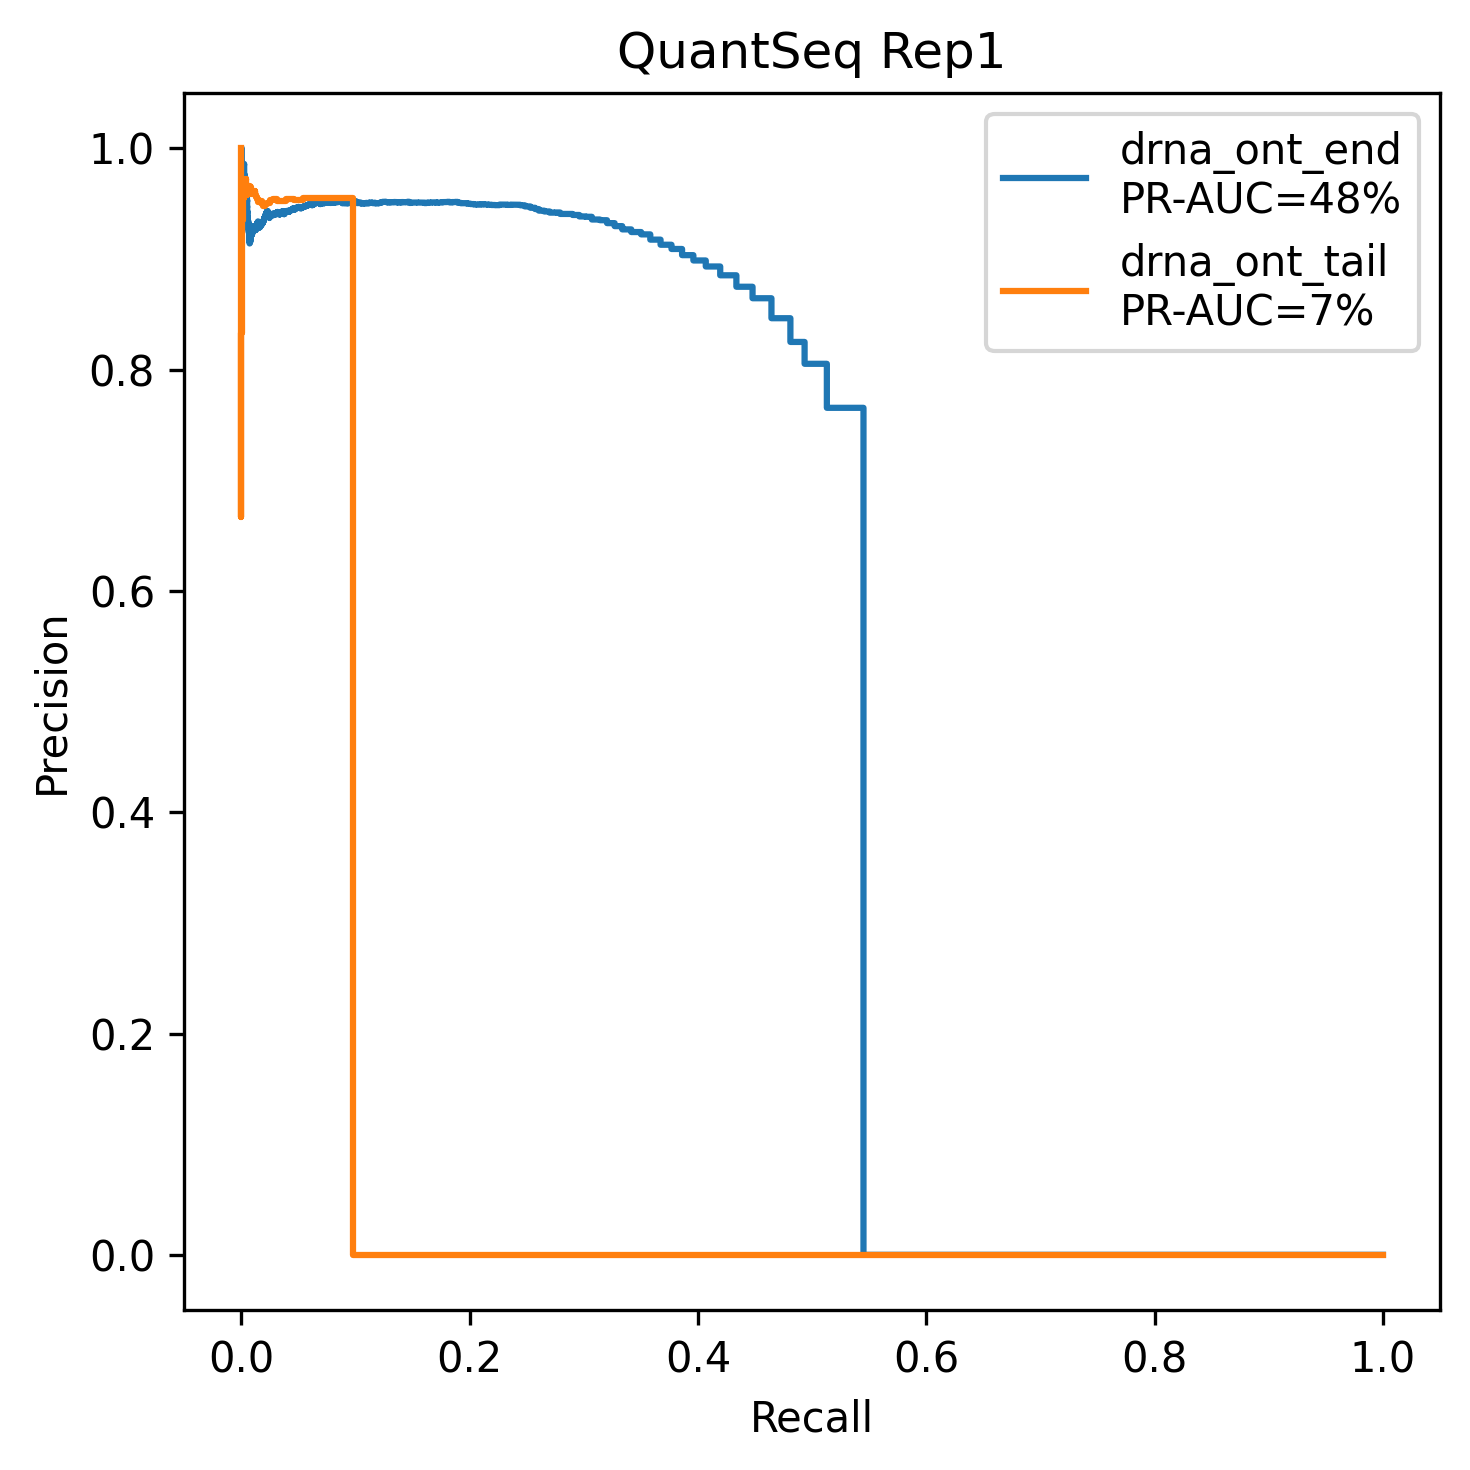

In [97]:
plt.figure(figsize=(5, 5), dpi=300)
plt.title('QuantSeq Rep1')
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve

#for label, df in [('cdna_ont', df_cdna_ont), ('cdna_pacbio', df_cdna_pacbio), ('drna_ont', df_drna_ont)]:
for label, df in [('drna_ont_end', df_drna_ont_end), ('drna_ont_tail', df_drna_ont_tail)]:
    
    ground_truth = list((df['polyA_site'] != -1).astype(int))
    score = df[f'tpm_{label}'].replace(-1, 0)
    
       
    prec, recall, threshold = precision_recall_curve(
        ground_truth, score, pos_label=1)
    prec[1] = 0
    prec[0] = 0
    
    label = f'{label}\nPR-AUC={int(auc(recall, prec) * 100)}%'
    plt.step(recall, prec, label=label)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])

plt.tight_layout()
#plt.savefig(snakemake.output['rep1'], bbox_inches = "tight")